In [1]:
import heapq
import random
import numpy as np


In [2]:
# Initialisation des variables globales
DateSimu = 0.0  # Temps simulé
Echeancier = []  # Liste des événements sous forme de tas (heap)

# Variables du système

NbBus = 0       # Nombre total de bus arrivés
NbBusRep = 0    # Nombre de bus nécessitant une réparation
QC = 0          # Nombre de bus dans la file de contrôle
QR = 0          # Nombre de bus dans la file de réparation`
BC = 0          # Statut du centre de contrôle (0: libre, 1: occupé)
BR = 0          # Nombre de postes de réparation occupés (max 2)
  # Variables pour les statistiques
AireQC = 0    # Aire sous la courbe de QC
AireQR = 0.0    # Aire sous la courbe de QR
AireBR = 0.0    # Aire sous la courbe de BR
AireBC = 0.0    # Aire sous la courbe de BC
# Variables pour le taux ajusté
AireBRActive = 0.0  # Aire pour les périodes actives
DureeActive = 0.0   # Temps total où les postes sont actifs

ArriveesQC = []  # Timestamps des arrivées dans la file de contrôle
ArriveesQR = []  # Timestamps des arrivées dans la file de réparation
TempsAttenteControle = []  # Temps d'attente pour chaque bus ayant accédé au contrôle
TempsAttenteReparation = []  # Temps d'attente pour chaque bus ayant accédé à la réparation
MaxAttenteQC = 0  # Temps d'attente maximum avant contrôle
MaxAttenteQR = 0  # Temps d'attente maximum avant réparation

MoyenneTempsAttenteControleReplications = [] # liste de temps d'atennte controle sur plusieures replications
MoyenneTempsAttenteReparationReplications = [] # liste de temps d'atennte reparation sur plusieures replications
TauxUtilisationReplication = []




DurCtrlMin = 15 # La duree de controle Minimal (en minutes)
DurCtrlMax = 65 # La duree de controle Maximal (en minutes)
DurRepaMin = 2.8*60.0 # La duree de reparation Minimal (en minutes)
DurRepaMax = 5.5*60.0 # La duree de reparation Maximal (en minutes)





In [3]:
# t : tuple (Evt, Date)
def insertIntoEcheanchier(t) :
  global Echeancier

  Echeancier.append(t)
  Echeancier.sort(key=lambda x: x[1])

In [58]:
# Definition des evenements
def ArriveeBus(date):
  global NbBus

  # Planifier la prochaine arriee de bus
  inter_arrival = np.random.exponential(3/4)*60.0 # Moyenne de 2 heures puis convertir en minutes
  insertIntoEcheanchier((0, date + inter_arrival ))

  # Incrementer le nombre de bus
  NbBus +=1
  #Inserer l'evenement ArriveeFileC
  insertIntoEcheanchier((1, date))

#Arrive file de controle
def ArriveeFileC(date):
  global QC, BC
  QC +=1
  if BC == 0:
    insertIntoEcheanchier((2, date))

# Arrivee file C pour la question 3
def ArriveeFileCQu3(date):
    global QC, ArriveesQC, BC
    QC += 1
    ArriveesQC.append(date)  # Stocke l'instant de l'arrivée
    if BC == 0:
        insertIntoEcheanchier((2, date))  # Si le poste de contrôle est libre, accès immédiat


def AccessControle(date):
  global QC, BC
  QC -= 1
  BC = 1 # Le centre de controle est maintenant occupe
  #Duree du controle (uniforme entre 15 min et 1h05)
  duree_controle = random.uniform(DurCtrlMin, DurCtrlMax)
  insertIntoEcheanchier((3, date + duree_controle))

# AccesControle pour la question 3
def AccessControleQu3(date):
    global QC, BC, ArriveesQC, TempsAttenteControle, MaxAttenteQC
    if QC > 0:
        QC -= 1
        BC = 1  # Le poste est maintenant occupé
        # Retirer le timestamp correspondant
        temps_attente = date - ArriveesQC.pop(0)
        
        TempsAttenteControle.append(temps_attente)
        MaxAttenteQC = max(MaxAttenteQC, temps_attente)
        # Planification de la fin du contrôle
        duree_controle = random.uniform(DurCtrlMin, DurCtrlMax)
        insertIntoEcheanchier((3, date + duree_controle))



# Je vais definir une fonction AccessControle pour la question 5 qui verifie que le nombre de bus
# ayant accede au controle est egale a m et declanche ensuite l'evenement fin simulation

def AccessControleQuestion5(date, m):
  global QC, BC, NbBus
  if NbBus == m:
    insertIntoEcheanchier((8, date))
  else:
     QC -= 1
     BC = 1 # Le centre de controle est maintenant occupe
     duree_controle = random.uniform(DurCtrlMin, DurCtrlMax)
     insertIntoEcheanchier((3, date + duree_controle))


def DepartControle(date):
  global QC, BC, QR


  BC = 0 # Le centre de controle est maintenant libre
  if QC > 0:
    insertIntoEcheanchier((2, date))
  # Probabilite de 30% de necessiter une reparation
  if random.random() < 0.3:
    insertIntoEcheanchier((4,date))

# Arrive file de reparation
def ArriveeFileR(date):
  global QR, BC, BR, NbBusRep
  QR += 1
  NbBusRep += 1
  if BR < 2:
    insertIntoEcheanchier((5,date))

# ArriveeFileR pour la question 3
def ArriveeFileRQu3(date):
    global QR, ArriveesQR, BR, NbBusRep
    QR += 1
    NbBusRep += 1
    ArriveesQR.append(date)  # Stocke l'instant de l'arrivée
    if BR < 2:
        insertIntoEcheanchier((5, date))  # Si un poste est libre, accès immédiat



# AccessReparation pour la question 3

def AccessReparationQu3(date):
    global QR, BR, ArriveesQR, TempsAttenteReparation, MaxAttenteQR
    if QR > 0:
        QR -= 1
        BR += 1  # Un poste est maintenant occupé
        # Retirer le timestamp correspondant
        temps_attente = date - ArriveesQR.pop(0)
        TempsAttenteReparation.append(temps_attente)
        MaxAttenteQR = max(MaxAttenteQR, temps_attente)
        # Planification de la fin de la réparation
        duree_reparation = random.uniform(DurRepaMin, DurRepaMax)
        insertIntoEcheanchier((6, date + duree_reparation))


def DebutSimulation(date, Duree):
  global NbBus, NbBusRep, QC, QR, BC, BR, AireQC, AireQR, AireBR, AireBRActive, DureeActive, DureeSimu

  # Initialisation de variables systeme
  DureeSimu = Duree
  NbBus = 0       # Nombre total de bus arrivés
  NbBusRep = 0    # Nombre de bus nécessitant une réparation
  QC = 0          # Nombre de bus dans la file de contrôle
  QR = 0          # Nombre de bus dans la file de réparation
  BC = 0          # Statut du centre de contrôle (0: libre, 1: occupé)
  BR = 0          # Nombre de postes de réparation occupés (max 2)
  # Variables pour les statistiques
  AireQC = 0.0    # Aire sous la courbe de QC
  AireQR = 0.0    # Aire sous la courbe de QR
  AireBR = 0.0    # Aire sous la courbe de BR
  AireBC = 0.0
  AireBRActive = 0.0
  DureeActive = 0.0
  # Planifier la premiere arrivee de bus
  Inter_arrival = random.expovariate(1/2) *60 # Moyenne de 2 heures
  insertIntoEcheanchier((0, DateSimu + Inter_arrival))
  # Planifier la fin de la simulation
  insertIntoEcheanchier((8, DureeSimu*60))

def FinSimulation(date):
  global Echeancier, NbBus, NbBusRep, AireQC, AireQR, AireBR,AireBC, TattenteMoyenneAvantControle, TattenteMoyenneAvantReparation,  TauxUtilisationAjuste, TauxUtilisationCentreReparation, DureeSimu
  global MoyenneTempsAttenteControleReplications, MoyenneTempsAttenteReparationReplications, TauxUtilisationReplication
  Echeancier = []
  TattenteMoyenneAvantControle = AireQC/NbBus
  MoyenneTempsAttenteControleReplications.append(TattenteMoyenneAvantControle)
  if NbBusRep > 0:
    TattenteMoyenneAvantReparation = AireQR/NbBusRep
    MoyenneTempsAttenteReparationReplications.append(TattenteMoyenneAvantReparation)

  else :
    TattenteMoyenneAvantReparation = 0
    MoyenneTempsAttenteReparationReplications.append(TattenteMoyenneAvantReparation)

  TauxUtilisationCentreReparation = AireBR/(2*DureeSimu*60)
  TauxUtilisationCentreControle = AireBC/(DureeSimu*60.0)
  TauxUtilisationReplication.append(TauxUtilisationCentreReparation)
  TauxUtilisationAjuste = AireBRActive / (2 * DureeActive) if DureeActive > 0 else 0

  print(f"Simulation pour la duree : {DureeSimu}")
  print(f"Temps d'attente moyen avant controle = {TattenteMoyenneAvantControle/60.0}\nTemps d'attente moyen avant reparation = {TattenteMoyenneAvantReparation/60.0}\nTaux d'utilisation du centre de reparation = {TauxUtilisationCentreReparation:.2%}\nTaux d'utilisation du centre de controle = {TauxUtilisationCentreControle}\n NbBus = {NbBus}" )
  print(f"Taux d'utilisation ajusté = {TauxUtilisationAjuste:.2%}\n Duree Active = {DureeActive/60}")
  print(f"AireQc = {AireQC}\t AireQR = {AireQR}\t AireBR = {AireBR}")
  print(f"la simulation a fini a : {date/60.0}")

# Fin simulation pour la question 3
def FinSimulationQu3(date):
    global Echeancier, NbBus, NbBusRep, AireQC, AireQR, AireBR, TattenteMoyenneAvantControle, TattenteMoyenneAvantReparation, TauxUtilisationCentreReparation, TempsAttenteControle, TempsAttenteReparation

    TattenteMoyenneAvantControle = sum(TempsAttenteControle) / len(TempsAttenteControle) if TempsAttenteControle else 0
    TattenteMoyenneAvantReparation = sum(TempsAttenteReparation) / len(TempsAttenteReparation) if TempsAttenteReparation else 0

    Echeancier = []
    TattenteMoyenneAvantControle = AireQC/NbBus

    if NbBusRep > 0:
      TattenteMoyenneAvantReparation = AireQR/NbBusRep
    else :
      TattenteMoyenneAvantReparation = 0

    TauxUtilisationCentreReparation = AireBR/(2*DureeSimu*60.0)

    
    

    print(f"Temps d'attente moyen avant controle = {TattenteMoyenneAvantControle/60.0}\nTemps d'attente moyen avant reparation = {TattenteMoyenneAvantReparation/60.0}\nTaux d'utilisation du centre de reparation = {TauxUtilisationCentreReparation}\n NbBus = {NbBus}" )
    print(f"AireQc = {AireQC}\t AireQR = {AireQR}\t AireBR = {AireBR}")
    print(f"Temps d'attente moyen avant contrôle (réel) = {TattenteMoyenneAvantControle / 60.0:.2f} heures")
    print(f"Temps d'attente moyen avant réparation (réel) = {TattenteMoyenneAvantReparation / 60.0:.2f} heures")
    print(f"Temps d'attente maximum avant contrôle = {MaxAttenteQC / 60.0:.2f} heures")
    print(f"Temps d'attente maximum avant réparation = {MaxAttenteQR / 60.0:.2f} heures")
    print(f"NbBus = {NbBus}")


def AccessReparation(date) :
  global QR, BR
  QR-=1
  BR+=1
  duree_reparation = random.uniform(DurRepaMin, DurRepaMax)
  insertIntoEcheanchier((6,DateSimu + duree_reparation))

def DepartReparation(date) :
  global QR, BR
  BR-=1
  if QR > 0 :
    insertIntoEcheanchier((5, DateSimu))





In [5]:
liste = [(1, 2), (2, 3), (0, 3)]
liste.sort(key=lambda x: x[1])
print(liste)

[(1, 2), (2, 3), (0, 3)]


# **Simulateur**

In [6]:
AireBRActive=0
DureeActive =0

In [50]:
def MiseAJourDesAires(D1,D2) :
  global AireQC, AireQR, AireBR,QC, QR, BR, AireBRActive, DureeActive  # Declare variables as global

  # si D2 > a fin simulation on ne met pas a jour D2
  AireQC = AireQC + (D2-D1)*QC
  AireQR = AireQR + (D2-D1)*QR
  AireBR = AireBR + (D2-D1)*BR

  

      # Identifier les périodes actives pour le calcul ajusté
  if BR >0 :  # Les postes sont actifs
      AireBRActive += (D2 - D1) * BR
      DureeActive += (D2 - D1)

In [8]:
# ArrivéeBus->0
# ArriveeFileC->1
# AccesControle->2
# DepartControle->3
# ArriveeFileR->4
# AccesReparation->5
# DepartReparation->6
# DebutSimulation->7
# FinSimulation->8
# MiseAJourDesAires->9

In [9]:
def Simulateur(Duree) :
  global DateSimu, Echeancier, DureeSimu
  DateSimu = 0.0
  Echeancier = []
  insertIntoEcheanchier((7, DateSimu))
  while Echeancier != [] :

    Evt, Date = Echeancier.pop(0)
    MiseAJourDesAires(DateSimu, Date)
    DateSimu = Date
    match Evt :
      case 0 :
        ArriveeBus(DateSimu)
      case 1 :
        ArriveeFileC(DateSimu)
      case 2 :
        AccessControle(DateSimu)
      case 3 :
        DepartControle(DateSimu)
      case 4 :
        ArriveeFileR(DateSimu)
      case 5 :
        AccessReparation(DateSimu)
      case 6 :
        DepartReparation(DateSimu)
      case 7 :
        DebutSimulation(DateSimu, Duree)
      case 8 :
        FinSimulation(DateSimu)



In [10]:
# Ce simulateur poura etre utiliser dans la question 5
def SimulateurQuestion5(m) :
  global DateSimu, Echeancier
  DateSimu = 0.0
  Echeancier = []
  insertIntoEcheanchier((7, DateSimu))
  while Echeancier != [] :

    Evt, Date = Echeancier.pop(0)
    MiseAJourDesAires(DateSimu, Date)
    DateSimu = Date
    match Evt :
      case 0 :
        ArriveeBus(DateSimu)
      case 1 :
        ArriveeFileC(DateSimu)
      case 2 :
        AccessControleQuestion5(DateSimu, m)
      case 3 :
        DepartControle(DateSimu)
      case 4 :
        ArriveeFileR(DateSimu)
      case 5 :
        AccessReparation(DateSimu)
      case 6 :
        DepartReparation(DateSimu)
      case 7 :
        DebutSimulation(DateSimu)
      case 8 :
        FinSimulation(DateSimu)


In [11]:
def SimulateurQuestion3() :
  global DateSimu, Echeancier
  DateSimu = 0.0
  Echeancier = []
  insertIntoEcheanchier((7, DateSimu))
  while Echeancier != [] :

    Evt, Date = Echeancier.pop(0)
    MiseAJourDesAires(DateSimu, Date)
    DateSimu = Date
    match Evt :
      case 0 :
        ArriveeBus(DateSimu)
      case 1 :
        ArriveeFileCQu3(DateSimu)
      case 2 :
        AccessControleQu3(DateSimu)
      case 3 :
        DepartControle(DateSimu)
      case 4 :
        ArriveeFileRQu3(DateSimu)
      case 5 :
        AccessReparationQu3(DateSimu)
      case 6 :
        DepartReparation(DateSimu)
      case 7 :
        DebutSimulation(DateSimu)
      case 8 :
        FinSimulationQu3(DateSimu)

In [56]:
Simulateur(40.0)

Simulation pour la duree : 40.0
Temps d'attente moyen avant controle = 1.2222701452567264
Temps d'attente moyen avant reparation = 2.2120119938931495
Taux d'utilisation du centre de reparation = 74.64%
Taux d'utilisation du centre de controle = 0.0
 NbBus = 55
Taux d'utilisation ajusté = 92.33%
 Duree Active = 32.336537737956895
AireQc = 4033.491479347197	 AireQR = 2521.6936730381904	 AireBR = 3582.7442368378606
la simulation a fini a : 40.0


### Question 2

In [13]:
MoyenneTempsAttenteControleReplications = [] # liste de temps d'atennte controle sur plusieures replications
MoyenneTempsAttenteReparationReplications = [] # liste de temps d'atennte reparation sur plusieures replications
TauxUtilisationReplication = []
nombre_replica = 1000
for replica in range(nombre_replica) : 
    Simulateur(160.0)
if(MoyenneTempsAttenteControleReplications != []):
    print(f"Moyenne Temps Attente avant controle sur {nombre_replica} replications :  {sum(MoyenneTempsAttenteControleReplications)/nombre_replica}")

Simulation pour la duree : 160.0
Temps d'attente moyen avant controle = 1.5378535415182448
Temps d'attente moyen avant reparation = 2.712863721684326
Taux d'utilisation du centre de reparation = 73.70%
 NbBus = 214
Taux d'utilisation ajusté = 84.21%
 Duree Active = 140.03182792621067
AireQc = 19746.039473094264	 AireQR = 9603.537574762513	 AireBR = 14150.12379719492
la simulation a fini a : 160.0
Simulation pour la duree : 160.0
Temps d'attente moyen avant controle = 2.025387698072385
Temps d'attente moyen avant reparation = 0.7261904380394365
Taux d'utilisation du centre de reparation = 62.12%
 NbBus = 221
Taux d'utilisation ajusté = 79.56%
 Duree Active = 124.91727810620327
AireQc = 26856.64087643983	 AireQR = 2352.857019247774	 AireBR = 11926.842849136823
la simulation a fini a : 160.0
Simulation pour la duree : 160.0
Temps d'attente moyen avant controle = 4.252660558924927
Temps d'attente moyen avant reparation = 5.5087168276145375
Taux d'utilisation du centre de reparation = 85.16

In [57]:
DureeExperiences= [40, 80,160,240]

for Duree in DureeExperiences :
    Simulateur(Duree)
    print("\n")

Simulation pour la duree : 40
Temps d'attente moyen avant controle = 1.322460219379797
Temps d'attente moyen avant reparation = 0.3700764689809256
Taux d'utilisation du centre de reparation = 58.51%
Taux d'utilisation du centre de controle = 0.0
 NbBus = 56
Taux d'utilisation ajusté = 79.26%
 Duree Active = 29.530874746646035
AireQc = 4443.466337116118	 AireQR = 310.8642339439775	 AireBR = 2808.667412055162
la simulation a fini a : 40.0


Simulation pour la duree : 80
Temps d'attente moyen avant controle = 1.097228720634089
Temps d'attente moyen avant reparation = 4.763633332727644
Taux d'utilisation du centre de reparation = 85.55%
Taux d'utilisation du centre de controle = 0.0
 NbBus = 109
Taux d'utilisation ajusté = 97.57%
 Duree Active = 70.1396463763699
AireQc = 7175.875832946942	 AireQR = 10575.265998655368	 AireBR = 8212.570083905717
la simulation a fini a : 80.0


Simulation pour la duree : 160
Temps d'attente moyen avant controle = 1.4576536640019806
Temps d'attente moyen avan

In [15]:
SimulateurQuestion5(115)

TypeError: DebutSimulation() missing 1 required positional argument: 'Duree'

In [ ]:
SimulateurQuestion3()

Temps d'attente moyen avant controle = 4.693540303942661
Temps d'attente moyen avant reparation = 3.314144670353635
Taux d'utilisation du centre de reparation = 0.9646791463866923
 NbBus = 239
AireQc = 67305.36795853777	 AireQR = 15510.197057255013	 AireBR = 18521.83961062449
Temps d'attente moyen avant contrôle (réel) = 4.69 heures
Temps d'attente moyen avant réparation (réel) = 3.31 heures
Temps d'attente maximum avant contrôle = 127.63 heures
Temps d'attente maximum avant réparation = 193.23 heures
NbBus = 239


[0.71, 0.76, 1.36, 2.49, 2.63, 2.97, 3.03, 4.19, 6.91, 7.29, 7.52, 9.26, 9.92, 9.97, 10.35, 11.86, 11.92, 12.09, 12.84, 13.08, 13.21, 15.71, 16.12, 16.72, 17.76, 19.7, 19.85, 20.73, 21.03, 21.24, 23.37, 25.01, 25.74, 25.78, 26.01, 27.01, 27.49, 27.81, 27.99, 28.26, 28.53, 30.29, 31.03, 32.65, 34.29, 34.33, 34.89, 35.48, 35.54, 35.87, 36.0, 36.26, 36.9, 37.16, 37.45, 39.07, 39.61, 41.0, 41.51, 42.31, 42.74, 43.0, 46.76, 47.69, 47.69, 48.43, 49.18, 49.92, 50.35, 50.88, 52.23, 52.56, 53.16, 53.95, 54.11, 55.56, 55.91, 57.13, 57.13, 57.28, 59.13, 59.48, 59.7, 59.92, 60.19, 60.4, 60.41, 60.72, 61.83, 61.99, 62.75, 62.99, 63.39, 64.21, 64.46, 65.48, 65.99, 66.49, 67.03, 67.2, 67.32, 67.38, 67.52, 68.24, 70.24, 70.46, 71.31, 71.38, 71.6, 71.67, 72.0, 72.03, 72.15, 72.2, 72.97, 73.48, 73.56, 75.23, 75.64, 76.03, 77.47, 78.6, 78.89, 80.83, 80.86, 80.91, 81.16, 82.11, 82.37, 82.73, 82.76, 83.57, 84.76, 84.89, 85.45, 87.85, 88.23, 89.33, 89.45, 89.91, 90.0, 90.26, 90.51, 91.72, 91.86, 93.33, 93.8

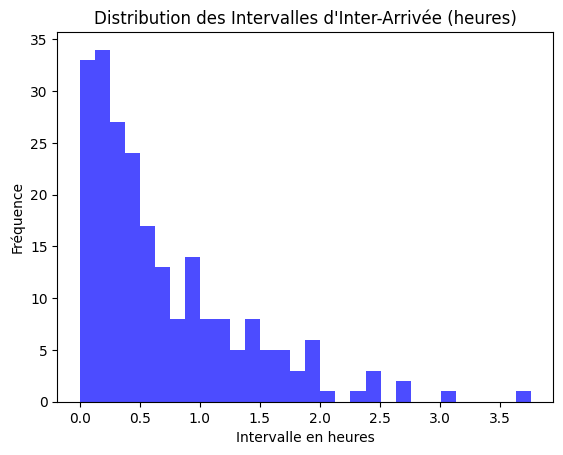

Test du χ² pour la loi exponentielle: 0.665063392197172
Test du χ² pour la loi normale: 0.0
Test du χ² pour la loi gamma: 0.39628565867645776
Estimation de lambda : 1.4294710327455922


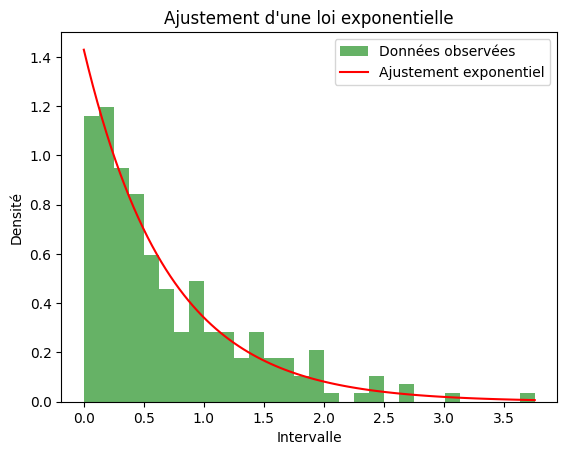

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2, expon, norm, gamma


####################loi d'inter-arrivée#####################################
# Charge les données du fichier et extraire les heures d'arrivée
arrivals = []
with open("DonneesControle.txt", "r") as file:
    for line in file:
        data = line.strip().split()  # Sépare les valeurs par espace
        arrivals.append(float(data[0]))  # Récupère uniquement l'heure d'arrivée (première valeur)

# Convertir les heures d'arrivée en temps cumulatifs (secondes) pour simplifier l'analyse
#arrivals_in_seconds = [arrival * 3600 for arrival in arrivals]  # Conversion en secondes

print(arrivals)
#intervals = [arrivals[i+1] - arrivals[i] for i in range(len(arrivals) - 1)]
intervals=np.diff(arrivals)
print(intervals)
# Histogramme des intervalles en heures
plt.hist(intervals, bins=30, alpha=0.7, color='blue')
plt.title("Distribution des Intervalles d'Inter-Arrivée (heures)")
plt.xlabel("Intervalle en heures")
plt.ylabel("Fréquence")
plt.show()

# Définir les bords des bins pour l'histogramme
num_bins = 30
observed_counts, bin_edges = np.histogram(intervals, bins=num_bins)
bin_width = bin_edges[1] - bin_edges[0]
bin_centers = bin_edges[:-1] + bin_width / 2

# Fréquences attendues pour chaque distribution
expon_fit = expon.fit(intervals)
expected_expon = len(intervals) * expon.pdf(bin_centers, *expon_fit) * bin_width

norm_fit = norm.fit(intervals)
expected_norm = len(intervals) * norm.pdf(bin_centers, *norm_fit) * bin_width

gamma_fit = gamma.fit(intervals)
expected_gamma = len(intervals) * gamma.pdf(bin_centers, *gamma_fit) * bin_width

# Test du χ² pour chaque distribution
chi2_expon = chi2.sf(np.sum((observed_counts - expected_expon)**2 / expected_expon), num_bins - 1)
chi2_norm = chi2.sf(np.sum((observed_counts - expected_norm)**2 / expected_norm), num_bins - 1)
chi2_gamma = chi2.sf(np.sum((observed_counts - expected_gamma)**2 / expected_gamma), num_bins - 1)

# Résultats des tests du χ²
print("Test du χ² pour la loi exponentielle:", chi2_expon)
print("Test du χ² pour la loi normale:", chi2_norm)
print("Test du χ² pour la loi gamma:", chi2_gamma)

# Calcul de la moyenne des intervalles
mean_interval = np.mean(intervals)

# Estimation de lambda
lambda_estimate = 1 / mean_interval
print(f"Estimation de lambda : {lambda_estimate}")

# Histogramme des intervalles
plt.hist(intervals, bins=30, density=True, alpha=0.6, color='g', label='Données observées')

# Création des points pour la courbe exponentielle
x = np.linspace(0, max(intervals), 100)
y = lambda_estimate * np.exp(-lambda_estimate * x)

# Ajout de la courbe exponentielle
plt.plot(x, y, 'r-', label='Ajustement exponentiel')
plt.title('Ajustement d\'une loi exponentielle')
plt.xlabel('Intervalle')
plt.ylabel('Densité')
plt.legend()
plt.show()




[0.63, 1.07, 0.79, 0.41, 0.61, 0.65, 0.74, 0.57, 0.74, 0.46, 0.49, 0.76, 0.94, 1.07, 0.54, 0.74, 1.01, 0.93, 0.47, 0.75, 0.27, 0.6, 0.51, 0.61, 0.58, 0.9, 1.06, 0.78, 0.31, 0.78, 0.69, 0.5, 0.52, 0.78, 1.08, 0.68, 0.85, 0.45, 0.52, 0.34, 0.76, 0.9, 0.33, 0.47, 0.38, 0.48, 0.62, 0.33, 1.06, 0.47, 0.6, 0.65, 0.3, 0.76, 0.66, 1.0, 1.03, 0.5, 0.91, 0.44, 0.62, 0.68, 0.84, 1.07, 0.48, 0.25, 1.06, 0.5, 0.43, 0.92, 0.66, 0.59, 0.7, 0.85, 0.49, 0.7, 0.88, 0.47, 0.41, 0.33, 0.73, 0.71, 1.04, 1.03, 0.26, 0.9, 0.74, 0.79, 0.34, 0.35, 0.69, 0.8, 0.84, 0.31, 0.42, 0.61, 0.26, 0.31, 0.54, 0.51, 1.08, 0.47, 0.55, 0.87, 0.43, 1.05, 1.07, 0.88, 0.41, 0.54, 0.41, 0.94, 0.34, 0.3, 0.59, 0.62, 0.55, 0.66, 0.59, 0.55, 0.89, 1.07, 0.96, 0.95, 0.56, 0.29, 0.95, 0.97, 0.31, 0.28, 0.76, 0.86, 0.76, 0.8, 1.04, 0.47, 1.02, 0.82, 0.86, 0.58, 0.82, 0.62, 0.27, 0.53, 0.4, 0.31, 0.66, 0.64, 0.99, 0.79, 1.0, 0.25, 0.83, 0.74, 1.08, 0.53, 0.82, 0.44, 1.02, 0.98, 0.64, 0.72, 0.37, 0.78, 1.08, 0.78, 0.62, 0.27, 0.32, 0.

Text(0, 0.5, 'Fréquence')

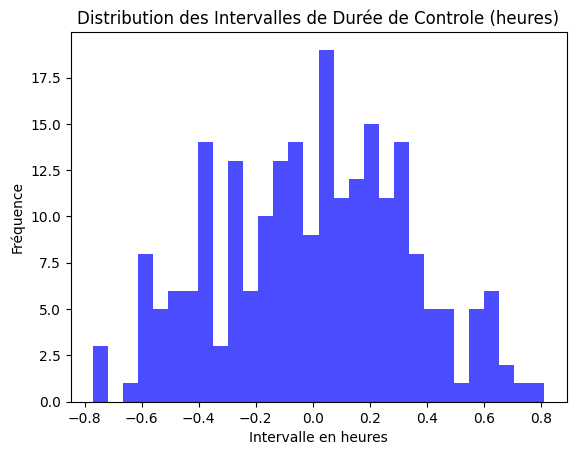

In [ ]:
################# loi de durée de contrôle ##################################
# Charge les données du fichier
durations = []
with open("DonneesControle.txt", "r") as file:
    for line in file:
        data = line.strip().split()  # Sépare les valeurs par espace
        durations.append(float(data[1]))  # Récupère uniquement la durée de contrôle (deuxième valeur)
print(durations)

durations_interval = np.diff(durations)
print(durations_interval)
# Histogramme des intervalles
plt.hist(durations_interval, bins=30, alpha=0.7, color='blue')
plt.title("Distribution des Intervalles de Durée de Controle (heures)")
plt.xlabel("Intervalle en heures")
plt.ylabel("Fréquence")